# Intermediate Machine Learning with scikit-learn

## Clustering

For an introduction to clustering algorithms, let us look at another visualization copied from the [scikit-learn documentation](http://scikit-learn.org/stable/modules/clustering.html). This is a visualization of several synthetic distributions in two dimensions to allow visualization.  We can  see that some distributions that do not have convex differentiation throw off some clutering algorithms.  Of course, given the low dimensionality, these examples are somewhat toys.


Comparing different clustering algorithms on toy datasets

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.



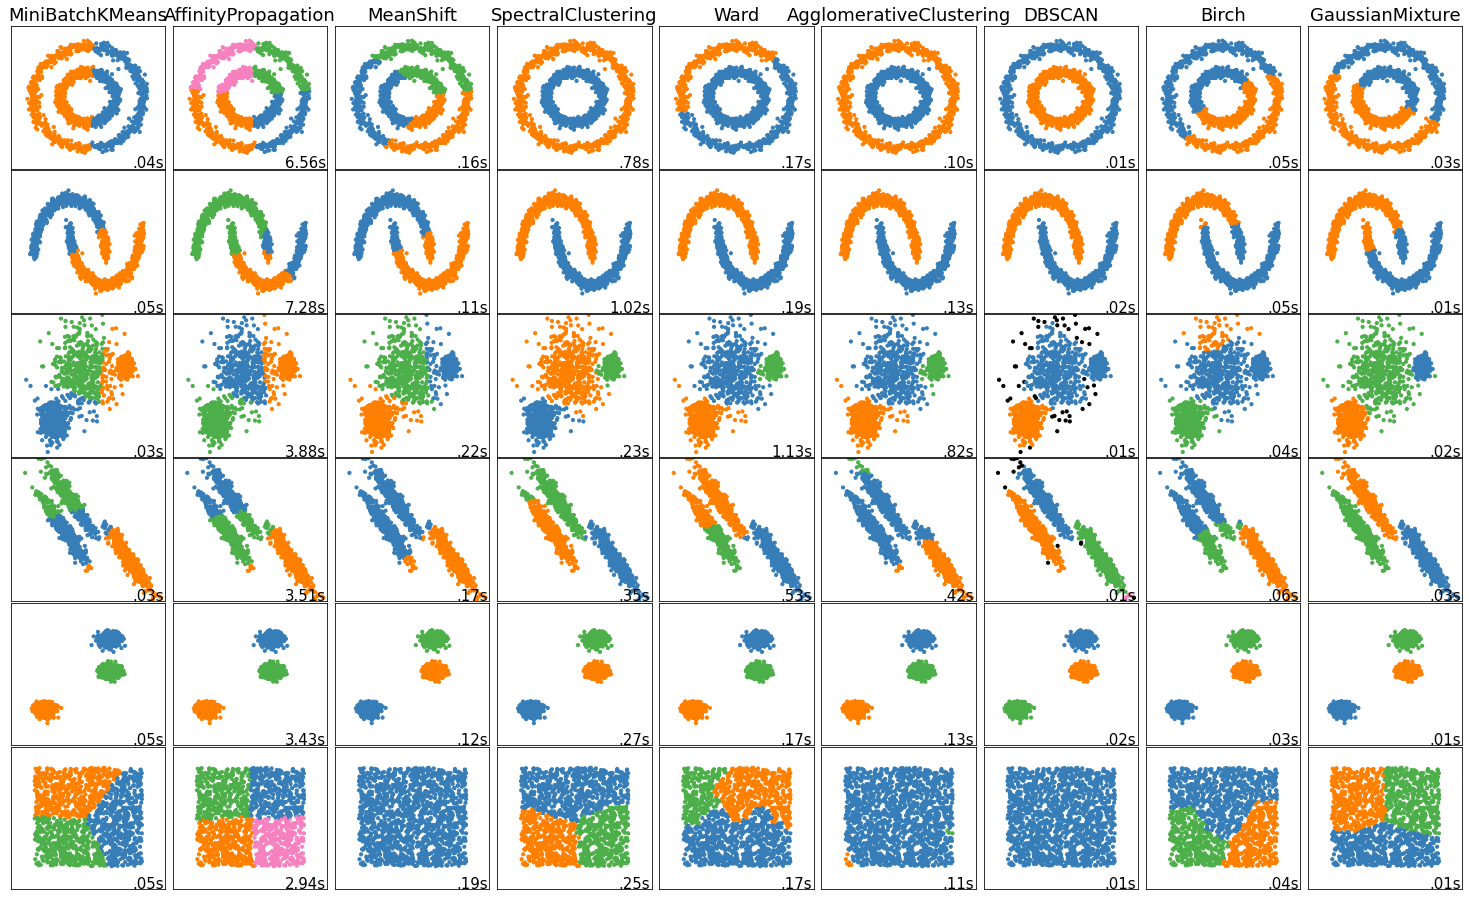

In [1]:
%matplotlib inline
%run src/plot_cluster_comparison.py

## Higher Dimensions

For examples with greater dimensionality, we will look first at a couple similar datasets in the scikit-learn samples.  A small-ish set of 506 houses sold in Boston in 1978 are available.  A different, larger sample dataset of 20k houses in California, from about 20 years later, is also available.  The features contained in the two datasets have both overlaps (albeit with different names for corresponding features) and differences.

Although normally clustering is used identify patterns where no *a priori* classes or target values are available, by using these datasets, we can test a certain intuition I have.  That is, my hunch would be that the way houses cluster along many feature dimensions will correspond to the clustering or distribution in the single price target.

My hypothesis can well be wrong without meaning that clustering is meaningless.  The semantic sense of the clusters may simply be something other than price—perhaps some other implicit feature we have a good name for, but also perhaps something with no obvious English word corresponding to the essence of the classes.  Let us explore this.

In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")

In [3]:
from sklearn import datasets
boston = datasets.load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


### Distances in Parametric Space

This is mostly for a later lesson, but many clustering algorithms are sensitive to the distances between points in a parameteric space in a unit-dependent way.  A later lesson on feature engineering will look at scaling data in more detail.  For some of the examples in this lesson, scaling will make little difference; however, for a few of them the absolute units of features becomes important.

Therefore, in the below examples, you will see line like this in the cells that fit models:

```python
X = StandardScaler().fit_transform(the_data)
```

In [5]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(boston.data)

## Cluster into N Classes

For the next few cells, we will use `SpectralClustering` to group our dataset into four synthetic classes.  Informally, we will call these classes "low", "mid_low", "mid_high", and "high" corresponding to our hypothesis that price is a good proxy for these classes.  From the documentation, the algorithm is described as follows:

> `SpectralClustering` does a low-dimension embedding of the affinity matrix between samples, followed by a KMeans in the low dimensional space. It is especially efficient if the affinity matrix is sparse and the [`pyamg`](https://github.com/pyamg/pyamg) module is installed. `SpectralClustering` requires the number of clusters to be specified. It works well for a small number of clusters but is not advised when using many clusters.

In [6]:
from sklearn import cluster
spectral = cluster.SpectralClustering(
        n_clusters=4, eigen_solver='arpack',
        affinity="nearest_neighbors")

spectral.fit(X)

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
                   coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
                   gamma=1.0, kernel_params=None, n_clusters=4,
                   n_components=None, n_init=10, n_jobs=None, n_neighbors=10,
                   random_state=None)

After fitting the data, what we get is labels for each sample.  These are simply integers in `range(n_clusters)`, with no inherent semantic meaning.  I.e. 0, 1, 2, or 3 in this case.

In [7]:
print(spectral.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 3 3 3 3 0 0 3 3 3 3 0
 0 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 2 2 2 2 2 

After we do the clustering, let us group the dataset by the cluster labels.  We will enhance the Pandas DataFrame that holds the data by adding columns for the derived category and the known price.  We also give hopefully more meaningful names to the clusters.  We only display some of the features to narrow discussion.

In [8]:
# Let us do minor Pandas manipulation to view clusters in an intuitive way
boston_df['category'] = spectral.labels_
boston_df['PRICE'] = boston.target
boston_clusters = boston_df.groupby('category').mean().sort_values('PRICE')
boston_clusters.index = ['low', 'mid_low', 'mid_high', 'high']
cols = ['PRICE'] + list(boston_clusters.columns[:-1])
boston_clusters = boston_clusters[cols]
boston_clusters[['PRICE', 'CRIM', 'RM', 'AGE', 'DIS']]

,PRICE,CRIM,RM,AGE,DIS
low,15.438710,13.209833,5.984137,89.731452,2.074494
mid_low,16.903704,0.394041,5.908296,94.533333,1.964785
mid_high,25.296429,1.975566,6.256393,84.448214,2.580846
high,25.465552,0.231280,6.448528,54.483946,4.901263


At first brush, it looks like price is pretty well differentiated by cluster.  Remember that price did not participate in the clustering model; so inasmuch as they correspond, it confirms our working hypothesis.

Other columns have interstingly different patterns.  Crime rate is high for the "low" category houses, then drops to almost none for "mid_low", "mid_high", and "high."  In contrast, the number of rooms varies little by category.  Distance to employment centers is low and similar for the first three categories of houses, but much larger for the "high" category houses.  Age of house shows a similar, but less dramatic, pattern as distance.

Let us try to get a handle on who well price is genuinely differentiated by category.

In [9]:
clusters = boston_df.groupby('category').PRICE.agg(['mean', 'median', 'std']).sort_values('mean')
clusters.index = ['low', 'mid_low', 'mid_high', 'high']
clusters

,mean,median,std
low,15.438710,14.10,6.956224
mid_low,16.903704,17.40,3.761187
mid_high,25.296429,22.35,10.851744
high,25.465552,23.10,8.156279


In a visual representation of the pattern we see *pretty good* but not overwhelming differentiation. One category of houses show a wide range of prices, while other categories tend to be more narrowly centered.

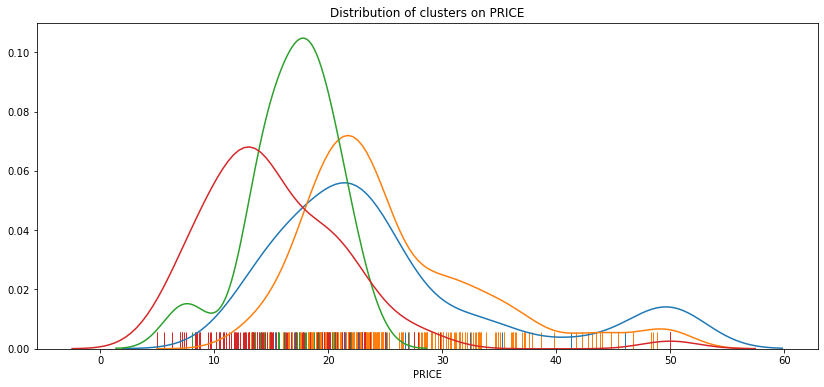

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(14,6))

sns.distplot(boston_df[boston_df.category == 0].PRICE, hist=False, rug=True)
sns.distplot(boston_df[boston_df.category == 1].PRICE, hist=False, rug=True)
sns.distplot(boston_df[boston_df.category == 2].PRICE, hist=False, rug=True)
sns.distplot(boston_df[boston_df.category == 3].PRICE, hist=False, rug=True)
ax.set_title("Distribution of clusters on PRICE");

Given our fairly successful confirmation of our hypothesis in regard to 1970s Boston housing prices  relative to independent features, let us try the same exercise with the much larger 1990s California housing prices dataset.

In [11]:
california = datasets.fetch_california_housing()
ca_df = pd.DataFrame(california.data, columns=california.feature_names)
ca_df['PRICE'] = california.target
ca_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [12]:
# Takes a little while to cluster 20k observations
from sklearn import cluster
spectral = cluster.SpectralClustering(
        n_clusters=4, eigen_solver='arpack',
        affinity="nearest_neighbors")

X = StandardScaler().fit_transform(california.data)
spectral.fit(X)

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
                   coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
                   gamma=1.0, kernel_params=None, n_clusters=4,
                   n_components=None, n_init=10, n_jobs=None, n_neighbors=10,
                   random_state=None)

In [14]:
# Let us do minor Pandas manipulation to view clusters in an intuitive way
ca_df['category'] = spectral.labels_
ca_clusters = ca_df.groupby('category').mean().sort_values('PRICE')
ca_clusters.index = ['low', 'mid_low', 'mid_high', 'high']
ca_clusters

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
low,3.381931,18.287234,29.195748,6.066689,342.659574,2.498475,37.707766,-119.419574,1.597234
mid_low,3.756794,29.193616,5.469117,1.077953,1209.019547,2.798686,37.919017,-121.664163,1.933959
mid_high,3.315919,36.520879,4.708582,1.050857,1174.851356,3.096355,33.975132,-118.142943,2.041876
high,4.708124,18.715980,5.801621,1.094623,2078.849143,3.479319,33.928652,-117.939347,2.320163


The clustering here seems to be mostly independent of price.  The only things there really seem differentiated in the cluster categories are age of house (young houses at extremes of price scale), number of rooms, and especially size of the cities where the houses are located.  Even the north/south or east/west distinctions I would expect in California houses are not strongly exposed by this technique.

We can look more specifically at the price distributions in groups, but it shows nothing relevant (nor does the more detailed graph; other than a somewhat bimodel distribution for all categories).

In [15]:
(ca_df
     .groupby('category')
     .PRICE
     .agg(['mean', 'median', 'std'])
     .sort_values('median')
)

,mean,median,std
category,,,
2,1.597234,1.4360,0.817272
0,1.933959,1.6150,1.188076
3,2.041876,1.8130,1.025222
1,2.320163,2.0235,1.203939


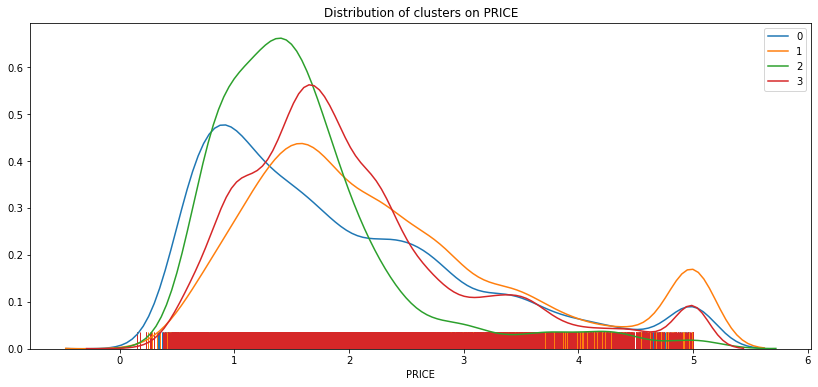

In [16]:
fig, ax = plt.subplots(figsize=(14,6))

sns.distplot(ca_df[ca_df.category == 0].PRICE, 
             label="0", hist=False, rug=True)
sns.distplot(ca_df[ca_df.category == 1].PRICE, 
             label="1", hist=False, rug=True)
sns.distplot(ca_df[ca_df.category == 2].PRICE, 
             label="2", hist=False, rug=True)
sns.distplot(ca_df[ca_df.category == 3].PRICE, 
             label="3", hist=False, rug=True)
ax.set_title("Distribution of clusters on PRICE");

## Cluster into an Unknown Number of Categories

In the first pass, we chose the number of clusters we expect in the data manually.  Many models require an `n_clusters` argument to select this.  However, some of the models determine the number of clusters from the data itself.  That is not uniformly better, but may let the "data speak" better in many cases.

Let us try our same analysis using the very good `DBSCAN` algorithm (Density-based spatial clustering of applications with noise).  This model is often the go-to choice for data scientists:

> The [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).

A result of this algorithm is that the number of clusters detected depends strongly on an epsilon hyperparameter that measures the acceptable distance to extend the region of a "core" and to reach non-core samples.  This makes scaling important to get consistent units among features, but also makes the choice of epsilon have a strong effect on number of identified clusters.  Notwithstanding the simple illustration below, the "core" region can be extended in any shape by identifying additional core points along any path.

"Noise points" in DBSCAN are given the class label -1.

<img src="img/DBSCAN.png">

In [17]:
import numpy as np
X = StandardScaler().fit_transform(boston.data)

for epsilon in np.arange(0.1, 1.8, 0.1):
    db = cluster.DBSCAN(eps=epsilon)
    db.fit(X)
    labels = np.unique(db.labels_)
    print("Epsilon=%.1f; labels=[%d .. %d]" % (epsilon, labels[0], labels[-1]))

Epsilon=0.1; labels=[-1 .. -1]
Epsilon=0.2; labels=[-1 .. -1]
Epsilon=0.3; labels=[-1 .. -1]
Epsilon=0.4; labels=[-1 .. -1]
Epsilon=0.5; labels=[-1 .. 3]
Epsilon=0.6; labels=[-1 .. 6]
Epsilon=0.7; labels=[-1 .. 8]
Epsilon=0.8; labels=[-1 .. 12]
Epsilon=0.9; labels=[-1 .. 13]
Epsilon=1.0; labels=[-1 .. 12]
Epsilon=1.1; labels=[-1 .. 12]
Epsilon=1.2; labels=[-1 .. 12]
Epsilon=1.3; labels=[-1 .. 11]
Epsilon=1.4; labels=[-1 .. 12]
Epsilon=1.5; labels=[-1 .. 9]
Epsilon=1.6; labels=[-1 .. 9]
Epsilon=1.7; labels=[-1 .. 9]


In [18]:
import numpy as np
X = StandardScaler().fit_transform(california.data)

for epsilon in np.arange(0.1, 1.8, 0.1):
    db = cluster.DBSCAN(eps=epsilon)
    db.fit(X)
    labels = np.unique(db.labels_)
    print("Epsilon=%.1f; labels=[%d .. %d]" % (epsilon, labels[0], labels[-1]))

Epsilon=0.1; labels=[-1 .. -1]
Epsilon=0.2; labels=[-1 .. 67]
Epsilon=0.3; labels=[-1 .. 149]
Epsilon=0.4; labels=[-1 .. 67]
Epsilon=0.5; labels=[-1 .. 24]
Epsilon=0.6; labels=[-1 .. 9]
Epsilon=0.7; labels=[-1 .. 15]
Epsilon=0.8; labels=[-1 .. 5]
Epsilon=0.9; labels=[-1 .. 3]
Epsilon=1.0; labels=[-1 .. 2]
Epsilon=1.1; labels=[-1 .. 3]
Epsilon=1.2; labels=[-1 .. 1]
Epsilon=1.3; labels=[-1 .. 0]
Epsilon=1.4; labels=[-1 .. 1]
Epsilon=1.5; labels=[-1 .. 1]
Epsilon=1.6; labels=[-1 .. 1]
Epsilon=1.7; labels=[-1 .. 2]


### Evaluating Price Hypothesis with DBSCAN

As you can see, by choosing different epsilon values, we can get wildly different numbers of clusters using DBSCAN.  This is not a bad thing, and being able to choose the granularity of clustering can be desirable.  However, on closer examination, we notice that  with various epsilon values, we still wind up either with most data samples in category -1 for noise, or in the overly generic category 0.  It may be that further hyperparameter tuning could improve this, but we will not do that for the California dataset.

In [19]:
X = StandardScaler().fit_transform(california.data)
ca_df['category'] = cluster.DBSCAN(eps=0.5).fit(X).labels_

(ca_df
     .groupby('category')
     .PRICE
     .agg(['mean', 'median', 'std', 'count'])
     .sort_values('count', ascending=False)
     .head()
)

,mean,median,std,count
category,,,,
0,2.069116,1.83500,1.089120,17321
-1,2.061644,1.55750,1.410778,2982
3,0.863806,0.82400,0.185888,103
2,4.965225,5.00001,0.134740,37
7,0.671294,0.63300,0.148533,34


Increasing `min_samples` from the default 5 to 20 *does* improve matters somewhat. Other hyperparameter values might continue to improve this.

In [20]:
X = StandardScaler().fit_transform(california.data)
ca_df['category'] = cluster.DBSCAN(eps=0.5, min_samples=20).fit(X).labels_

(ca_df
     .groupby('category')
     .PRICE
     .agg(['mean', 'median', 'std', 'count'])
     .sort_values('count', ascending=False)
     .head()
)

,mean,median,std,count
category,,,,
1,2.147692,1.898,0.991929,8373
-1,2.057686,1.621,1.350529,6400
0,1.967841,1.740,1.129559,5846
2,1.868238,1.839,0.417683,21


With the Boston dataset we can get much less problem with noise and dominance of cluster 0.  Of course, we already had reasonable confirmation of our initial price-based clustering with spectral clustering.

In [21]:
X = StandardScaler().fit_transform(boston.data)
boston_df['category'] = cluster.DBSCAN(eps=1.6).fit(X).labels_

(boston_df
     .groupby('category')
     .PRICE
     .agg(['mean', 'median', 'std', 'count'])
     .sort_values('count', ascending=False)
     .head()
)

,mean,median,std,count
category,,,,
0,24.856364,23.1,7.399777,275
8,16.343373,15.1,6.391690,83
-1,22.579592,18.2,13.744499,49
9,12.670370,12.7,4.245433,27
2,17.285714,17.6,2.542215,14


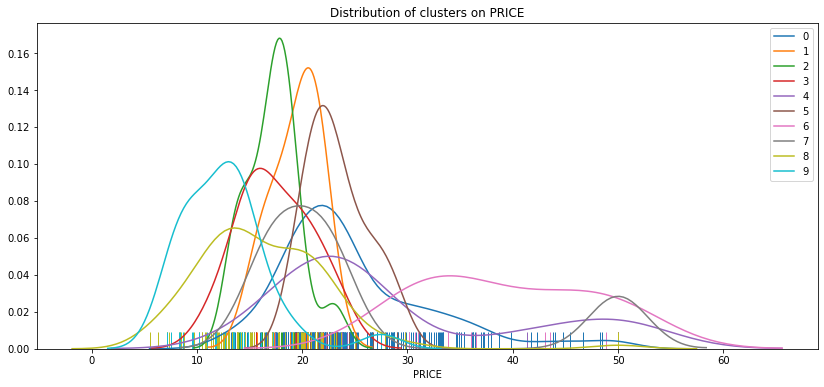

In [22]:
# Exclude the noise =-1 in the graph
fig, ax = plt.subplots(figsize=(14,6))

for cat in range(boston_df.category.max()+1):
    sns.distplot(boston_df[boston_df.category == cat].PRICE, 
                 label=str(cat), hist=False, rug=True)
ax.set_title("Distribution of clusters on PRICE");

I believe our conclusion at this point should be that there are several price-centric categories of houses in the Boston dataset, but for other classes that are clustered, different factors take precedent.  Five or six of the 10 categories have steep Gaussian slopes, that rest are distributed in ways suggesting price is not crucial.

## HDBSCAN: A Better DBSCAN?

A colleague of mine advised me to try out an improved variant of DBSCAN called [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/index.html).  This algorithm is not currently included in scikit-learn, but it follows the same API.  The basic idea in HDBSCAN is that the algorithm will dynamically adjust the epsilon value in regions of varying density.  From the [Campello, Moulavi, and Sander](http://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14) research paper that introduced it:

> We propose a theoretically and practically improved density-based, hierarchical clustering method, providing a clustering hierarchy from which a simplified tree of significant clusters can be constructed. For obtaining a “flat” partition consisting of only the most significant clusters (possibly corresponding to different density thresholds), we propose a novel cluster stability measure, formalize the problem of maximizing the overall stability of selected clusters, and formulate an algorithm that computes an optimal solution to this problem. We demonstrate that our approach outperforms the current, state-of-the-art, density-based clustering methods on a wide variety of real world data.

In [23]:
from hdbscan import HDBSCAN

In [24]:
X = StandardScaler().fit_transform(boston.data)

hdb = HDBSCAN()
hdb.fit(X)
labels = np.unique(hdb.labels_)
print("Labels=[%d .. %d]" % (labels[0], labels[-1]))

Labels=[-1 .. 9]


In [25]:
boston_df['category'] = hdb.labels_
(boston_df
     .groupby('category')
     .PRICE
     .agg(['mean', 'median', 'std', 'count'])
     .sort_values('count', ascending=False)
     .head()
)

,mean,median,std,count
category,,,,
9,24.680370,23.05,7.020386,270
3,16.414815,15.20,6.449847,81
-1,20.850980,16.30,13.352264,51
2,12.100000,12.25,3.099935,26
0,27.729167,24.75,9.589735,24


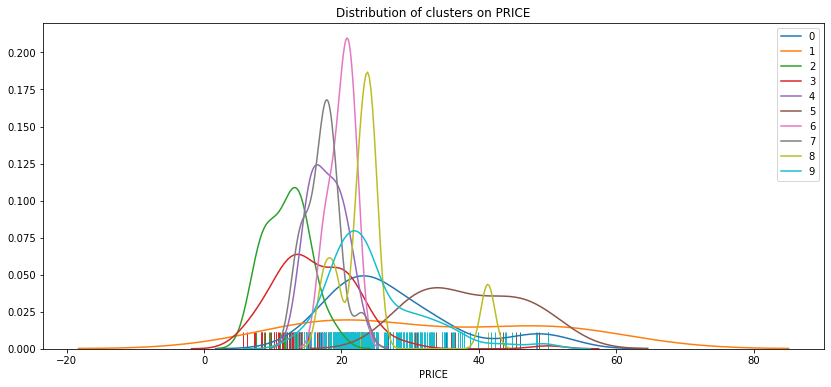

In [26]:
# Exclude the noise =-1 in the graph
fig, ax = plt.subplots(figsize=(14,6))

for cat in range(boston_df.category.max()+1):
    sns.distplot(boston_df[boston_df.category == cat].PRICE, 
                 label=str(cat), hist=False, rug=True)
ax.set_title("Distribution of clusters on PRICE");

On the relatively confirmatory Boston housing dataset, HDBSCAN produces sharper price peaks than other clustering approaches we have looked at. However, as with other techniques, it appears to identify several price centers *and also* other clusters whose identity is not chiefly price-focused.

HDBSCAN both gave us automated determination of number of clusters and avoided the need for manually tweaking epsilon. But the Boston dataset has been easy, let us try against the California housing dataset.  

In [27]:
X = StandardScaler().fit_transform(california.data)

hdb = HDBSCAN(min_cluster_size=20)
hdb.fit(X)
labels = np.unique(hdb.labels_)
print("Labels=[%d .. %d]" % (labels[0], labels[-1]))

Labels=[-1 .. 2]


In [28]:
ca_df['category'] = hdb.labels_
(ca_df
     .groupby('category')
     .PRICE
     .agg(['mean', 'median', 'std', 'count'])
     .sort_values('count', ascending=False)
     .head()
)

,mean,median,std,count
category,,,,
1,2.138698,1.898,0.970362,7889
-1,2.062055,1.625,1.342334,7384
2,1.978723,1.762,1.114383,5347
0,0.820150,0.812,0.130560,20


This approach is still relatively unsucessessful.  At least it does not identify the assumed price-basis of the clusters.  It may be time to reject our hypothesis relative to this dataset.

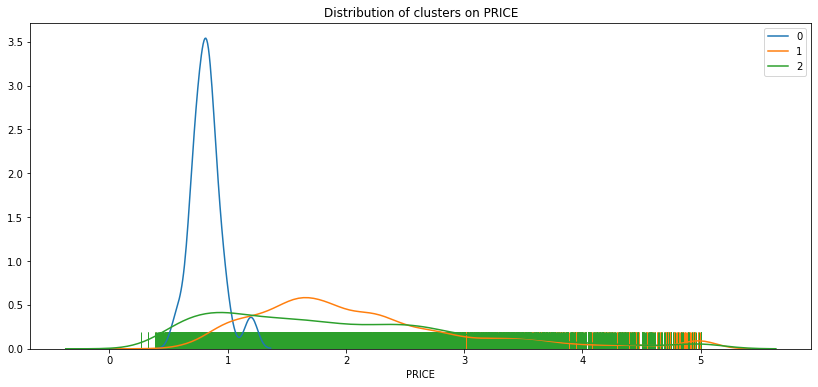

In [29]:
# Exclude the noise =-1 in the graph
fig, ax = plt.subplots(figsize=(14,6))

for cat in range(ca_df.category.max()+1):
    sns.distplot(ca_df[ca_df.category == cat].PRICE, 
                 label=str(cat), hist=False, rug=True)
ax.set_title("Distribution of clusters on PRICE");

## Evaluating Clustering

From the [scikit-learn documentation](http://scikit-learn.org/stable/modules/clustering.htm):

> Evaluating the performance of a clustering algorithm is not as trivial as counting the number of errors or the precision and recall of a supervised classification algorithm. In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar that members of different classes according to some similarity metric.

The problem, of course, is that in **unsupervised** learning, you are more-or-less assured of not having a "ground truth" since you are trying to tease that out of the data.  In the examples above, we partially faked it by having a hypothesis about ground truth; but that hypothesis seemed supportable in one dataset and unsupportable in a different related dataset.$^1$

<hr/>
<small>$^1$<i>It is accurate to say that we have failed to validate our hypothesis, not that we have proven it false.  It might still be that some additional clustering model we have not tried—or some hyperparameters to those we tried—would produce price-linked clusters in the California dataset of similar strength to those the Boston dataset readily showed.</i></small>
<hr/>

One kind of validation that is possible to perform is to see whether different clustering algorithms produce similar classes, and assign observations to the same class as each other.  If there is agreement, that lends *some* extra weight to the idea that the clusters represent an underlying phenomenon of the data.

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.  This method is symmetric and independent of the particular labels an algorithm uses.  It depends only on collections of samples in the same class under one regime correspondng to the same collection under another regime.  *Adjusted mutual information score* is similar to *adjusted Rand score*.

In [30]:
# Fit several clustering models that take n_clusters
from sklearn import cluster

X = StandardScaler().fit_transform(boston.data)

models = [cluster.SpectralClustering(n_clusters=4), 
          cluster.KMeans(n_clusters=4), 
          cluster.MiniBatchKMeans(n_clusters=4), 
          cluster.AgglomerativeClustering(n_clusters=4)]

for model in models:
    model.fit(X)
    print(model.__class__.__name__)
    print("\tFirst 5 labels", model.labels_[:5])
    print("\t", len(model.labels_))

SpectralClustering
	First 5 labels [0 0 0 0 0]
	 506
KMeans
	First 5 labels [1 1 1 1 1]
	 506
MiniBatchKMeans
	First 5 labels [2 2 2 2 2]
	 506
AgglomerativeClustering
	First 5 labels [0 0 0 0 0]
	 506


In the example above, all four clustering models selected assigned the same class to the first five samples.  However, the particular number given to that class might be any of the four possible values (depending even on random seeds).  The label numbers are not interesting, only the samples assigned to them.

In [31]:
# ... then measure their pairwise similarity
from sklearn import metrics
from itertools import combinations

for clust1, clust2 in combinations(models, 2):
    print(clust1.__class__.__name__, "versus", clust2.__class__.__name__)
    print("\tRand score:", metrics.adjusted_rand_score(clust1.labels_, clust2.labels_))
    print("\tMutual info:", metrics.adjusted_mutual_info_score(clust1.labels_, clust2.labels_))


SpectralClustering versus KMeans
	Rand score: 0.5046438951150365
	Mutual info: 0.6239711455275184
SpectralClustering versus MiniBatchKMeans
	Rand score: 0.4922632554730044
	Mutual info: 0.6226473112826177
SpectralClustering versus AgglomerativeClustering
	Rand score: 0.550129525055905
	Mutual info: 0.7298262007281899
KMeans versus MiniBatchKMeans
	Rand score: 0.9494492087263025
	Mutual info: 0.9383188593638896
KMeans versus AgglomerativeClustering
	Rand score: 0.4348913252800702
	Mutual info: 0.6017675727107918
MiniBatchKMeans versus AgglomerativeClustering
	Rand score: 0.44206795791423525
	Mutual info: 0.6076283566644346


Both measures made range between zero and one.  As one would expect, the closely related `KMeans` and `MiniBatchKMeans` are closely similar.  Other pairs are moderately similar; certainly they are much more similar than e.g. random choices of labels, which would produce scores of zero (the *adjusted* part discounts for expected random intersections)

## Next Lesson

**Feature Engineering**: In the current lessson we looked at several clustering models.  Besides their underlying algorithmic differences, a key difference among them is whether they choose a number of clusters based on the data itself or produce a specified number of classes. 

In this lesson and some previous one, we have done some feature engineering in passing. In the next lessons we will address dimensionality reduction, feature engineering, and feature selection, in more specific detail.

<a href="Decomposition.ipynb"><img src="img/open-notebook.png" align="left"/></a>